In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/ltfs-dataset/state_seg2.pt
/kaggle/input/ltfs-dataset/train_fwYjLYX.csv
/kaggle/input/ltfs-dataset/LT.NS.csv
/kaggle/input/ltfs-dataset/test_1eLl9Yf.csv
/kaggle/input/ltfs-dataset/holidays.csv


In [2]:
import pandas as pd
pd.options.display.max_columns = 500
pd.options.display.max_rows = 500
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import sys
import seaborn as sns

In [3]:
import pandas as pd
import numpy as np
import json
pd.options.display.max_rows = 1000
pd.options.display.max_columns = 1000

from tqdm import tqdm
import copy
import multiprocessing as mp
import time
import json
import matplotlib.pyplot as plt
import random

from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from functools import partial
from sklearn.model_selection import KFold, GroupKFold
from sklearn.metrics import cohen_kappa_score, accuracy_score
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence
from torch.nn.utils.rnn import pad_packed_sequence
from sklearn.preprocessing import MinMaxScaler

In [4]:
def create_features(df, ):
    """Creates time series features from datetime index"""
    df['dayofweek'] = df['application_date'].dt.dayofweek
    df['quarter'] = df['application_date'].dt.quarter
    df['month'] = df['application_date'].dt.month
    df['year'] = df['application_date'].dt.year
    df['dayofyear'] = df['application_date'].dt.dayofyear
    df['dayofmonth'] = df['application_date'].dt.day
    df['weekofyear'] = df['application_date'].dt.weekofyear
    return df

In [5]:
# sys.path.append('../ml_modules/')

In [6]:
train = pd.read_csv('/kaggle/input/ltfs-dataset/train_fwYjLYX.csv')
test = pd.read_csv('/kaggle/input/ltfs-dataset/test_1eLl9Yf.csv')
train.shape, test.shape

((80402, 6), (180, 3))

In [7]:
train.head(2)

,application_date,segment,branch_id,state,zone,case_count
0,2017-04-01,1,1.0,WEST BENGAL,EAST,40.0
1,2017-04-03,1,1.0,WEST BENGAL,EAST,5.0


In [8]:
train.segment.value_counts(1)

1    0.832044
2    0.167956
Name: segment, dtype: float64

In [9]:
test['application_date'] = pd.to_datetime(test.application_date)
test = test.sort_values(by='application_date')
train['application_date'] = pd.to_datetime(train.application_date)
train = train.sort_values(by='application_date')

In [10]:
print(train.application_date.min(), train.application_date.max())
print(test.application_date.min(), test.application_date.max())

2017-04-01 00:00:00 2019-07-23 00:00:00
2019-07-06 00:00:00 2019-10-24 00:00:00


In [11]:
stock = pd.read_csv('/kaggle/input/ltfs-dataset/LT.NS.csv')
stock['Date'] = pd.to_datetime(stock['Date'])
print(stock.shape)
stock.head(1)

(1231, 7)


,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-01-19,1068.670044,1082.0,1067.930054,1076.569946,975.331055,2087948.0


In [12]:
holidays = pd.read_csv('/kaggle/input/ltfs-dataset/holidays.csv')
holidays['date_iso'] = pd.to_datetime(holidays.date_iso)
print(holidays.shape)
holidays.head(1)

(183, 3)


,date_iso,name,type
0,2017-01-01,New Year's Day,National holiday


In [13]:
holiday_name_mapping = dict(zip(holidays.name.unique(), range(1, holidays.name.nunique()+1)))
holiday_type_mapping = dict(zip(holidays.type.unique(), range(1, holidays.type.nunique()+1)))
holidays['name_mapped'] = holidays.name.map(holiday_name_mapping).astype(int)
holidays['type_mapped'] = holidays.type.map(holiday_type_mapping).astype(int)

In [14]:
holidays.head()

,date_iso,name,type,name_mapped,type_mapped
0,2017-01-01,New Year's Day,National holiday,1,1
1,2017-01-05,Guru Govind Singh Jayanti,Observance,2,2
2,2017-01-14,Pongal,National holiday,3,1
3,2017-01-26,Republic Day,National holiday,4,1
4,2017-01-28,Chinese New Year,Observance,5,2


In [15]:
train = train[train.segment == 2].reset_index(drop=True)
test = test[test.segment == 2].reset_index(drop=True)
train.shape, test.shape

((13504, 6), (93, 3))

In [16]:
state_mapping = dict(zip(train.state.unique(), range(1, train.state.nunique()+1)))

In [17]:
train.head()

,application_date,segment,branch_id,state,zone,case_count
0,2017-04-01,2,NaN,TAMIL NADU,NaN,458.0
1,2017-04-01,2,NaN,PUNJAB,NaN,0.0
2,2017-04-01,2,NaN,TRIPURA,NaN,0.0
3,2017-04-01,2,NaN,WEST BENGAL,NaN,43.0
4,2017-04-01,2,NaN,UTTAR PRADESH,NaN,27.0


In [18]:
# creating state level test set
new_test = []
import copy
for i, row in test.iterrows():
    for state in train.state.unique():
        _dict = copy.deepcopy(row)
        _dict['state'] = state
        new_test.append(_dict)
test_  = pd.DataFrame(new_test)
test_ = test_.drop(columns=['id'])
print(test_.shape)
test_.head()

(1488, 3)


,application_date,segment,state
0,2019-07-24,2,TAMIL NADU
0,2019-07-24,2,PUNJAB
0,2019-07-24,2,TRIPURA
0,2019-07-24,2,WEST BENGAL
0,2019-07-24,2,UTTAR PRADESH


In [19]:
df_ = train.groupby(['application_date', 'state'])['case_count'].sum().reset_index()
df_ = pd.concat([df_, test_[['application_date', 'state']]], 0, sort=False).reset_index(drop=True)
df_ = df_.sort_values(by=['state','application_date']).reset_index(drop=True)

df_['state_mapped'] = df_.state.map(state_mapping).astype(int)
print(df_.shape)
df_.head(5)

(14992, 4)


,application_date,state,case_count,state_mapped
0,2017-04-01,ASSAM,0.0,9
1,2017-04-02,ASSAM,0.0,9
2,2017-04-03,ASSAM,0.0,9
3,2017-04-04,ASSAM,0.0,9
4,2017-04-05,ASSAM,0.0,9


In [20]:
df_ = df_.merge(holidays, left_on='application_date', right_on='date_iso', how='left')
df_.head(5)

,application_date,state,case_count,state_mapped,date_iso,name,type,name_mapped,type_mapped
0,2017-04-01,ASSAM,0.0,9,NaT,NaN,NaN,NaN,NaN
1,2017-04-02,ASSAM,0.0,9,NaT,NaN,NaN,NaN,NaN
2,2017-04-03,ASSAM,0.0,9,NaT,NaN,NaN,NaN,NaN
3,2017-04-04,ASSAM,0.0,9,2017-04-04,Rama Navami,Observance,16.0,2.0
4,2017-04-05,ASSAM,0.0,9,NaT,NaN,NaN,NaN,NaN


In [21]:
# df_ = df_.merge(stock, left_on='application_date', right_on='Date', how='left')
# df_[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']] = df_[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']].fillna(method='ffill').fillna(method='bfill')

In [22]:
df_ = create_features(df_)
print(df_.shape)
df_.head(2)

(14992, 16)


,application_date,state,case_count,state_mapped,date_iso,name,type,name_mapped,type_mapped,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
0,2017-04-01,ASSAM,0.0,9,NaT,NaN,NaN,NaN,NaN,5,2,4,2017,91,1,13
1,2017-04-02,ASSAM,0.0,9,NaT,NaN,NaN,NaN,NaN,6,2,4,2017,92,2,13


In [23]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [24]:
num_columns = ['dayofweek', 'quarter', 'month', 'year', 'dayofyear', 'dayofmonth', 'weekofyear',
#                'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'
              ]
# ss = MinMaxScaler(feature_range=(0,1))
# ss.fit(df_[num_columns])
# df_[num_columns] = ss.transform(df_[num_columns])

In [25]:
target = 'case_count'
# ss_target = MinMaxScaler(feature_range=(0,1))
# ss_target.fit(df_[[target]])
# df_[[target]] = ss_target.transform(df_[[target]])

In [26]:
df_[['name_mapped', 'type_mapped']] = df_[['name_mapped', 'type_mapped']].fillna(0)

In [27]:
# seq_len = 365
# tr_index = df_[df_.case_count.notnull()].index[seq_len:-91]
# vl_index = df_[df_.case_count.notnull()].index[-91:-1]
# te_index = df_[df_.case_count.isnull()].index
# len(tr_index), len(vl_index), len(te_index)

seq_len = 365
tr_index, vl_index, te_index = [], [], []
group_key = ['state']
for i, grp in df_.groupby(group_key):
    tr_index.extend(grp[grp.case_count.notnull()].index[seq_len:-90])
    vl_index.extend(grp[grp.case_count.notnull()].index[-90:])
    te_index.extend(grp[grp.case_count.isnull()].index)

len(tr_index), len(vl_index), len(te_index)

(6224, 1440, 1488)

In [28]:
print(df_.iloc[tr_index].application_date.min(), df_.iloc[tr_index].application_date.max())
print(df_.iloc[vl_index].application_date.min(), df_.iloc[vl_index].application_date.max())

2018-04-01 00:00:00 2019-04-24 00:00:00
2019-04-25 00:00:00 2019-07-23 00:00:00


In [29]:
df_['case_count'] = (df_.case_count + 1).map(np.log)
df_['case_count'].describe()

count    13504.000000
mean         4.998772
std          2.794555
min          0.000000
25%          4.007333
50%          5.918894
75%          6.941190
max          9.531554
Name: case_count, dtype: float64

In [30]:
hist_cat_columns = ['name_mapped', 'type_mapped', 'state_mapped']
hist_num_columns = ['case_count', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear', 'dayofmonth', 'weekofyear', 
#                     'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'
                   ]
curr_cat_columns = ['name_mapped', 'type_mapped']
curr_num_columns = ['dayofweek', 'quarter', 'month', 'year', 'dayofyear', 'dayofmonth', 'weekofyear']
# curr_cat_columns = []
# curr_num_columns = []
target = 'case_count'

class TabularDataset(Dataset):
    def __init__(self, df, indices, seq_len=365, is_test=False):
        self.df = df
        self.seq_len = seq_len
        self.is_test = is_test
        self.indices = indices
                
    def __len__(self):
        return len(self.indices)
        
    def __getitem__(self, ind):
        idx = self.indices[ind]
        hist_df = self.df.iloc[idx-self.seq_len:idx]
        
        return [
            hist_df[hist_cat_columns].values,
            hist_df[hist_num_columns].values,
            self.df.iloc[idx][curr_cat_columns].values,
            self.df.iloc[idx][curr_num_columns].values,
            self.df.iloc[idx][target] if not self.is_test else idx,
            idx
        ]

In [31]:
cat_dims = [int(df_[col].nunique()) for col in hist_cat_columns]
emb_dims = [(x+1, min(50, (x+2) // 2)) for x in cat_dims]
print(cat_dims)
print(emb_dims)

[67, 5, 16]
[(68, 34), (6, 3), (17, 9)]


In [32]:
def pad_collate(batch):
    hist_cat_x, hist_num_x, curr_cat_x, curr_num_x, y, idx = zip(*batch) 
    return (torch.LongTensor(hist_cat_x), 
            torch.Tensor(hist_num_x), 
            torch.LongTensor(curr_cat_x), 
            torch.Tensor(curr_num_x), 
            torch.Tensor(y),
            torch.Tensor(idx)
            
           )

In [33]:
df_ = df_.reset_index(drop=True)
df_.head()

,application_date,state,case_count,state_mapped,date_iso,name,type,name_mapped,type_mapped,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
0,2017-04-01,ASSAM,0.0,9,NaT,NaN,NaN,0.0,0.0,5,2,4,2017,91,1,13
1,2017-04-02,ASSAM,0.0,9,NaT,NaN,NaN,0.0,0.0,6,2,4,2017,92,2,13
2,2017-04-03,ASSAM,0.0,9,NaT,NaN,NaN,0.0,0.0,0,2,4,2017,93,3,14
3,2017-04-04,ASSAM,0.0,9,2017-04-04,Rama Navami,Observance,16.0,2.0,1,2,4,2017,94,4,14
4,2017-04-05,ASSAM,0.0,9,NaT,NaN,NaN,0.0,0.0,2,2,4,2017,95,5,14


In [34]:
batchsize = 16
train_dataset = TabularDataset(df_, indices=tr_index, seq_len=seq_len)
train_dataloader = DataLoader(train_dataset, batchsize, shuffle=True, num_workers=1, collate_fn=pad_collate)

valid_dataset = TabularDataset(df_, indices=vl_index, seq_len=seq_len, is_test=False)
valid_dataloader = DataLoader(valid_dataset, 1, shuffle=False, num_workers=1, collate_fn=pad_collate)

test_dataset = TabularDataset(df_, indices=te_index, seq_len=seq_len, is_test=True)
test_dataloader = DataLoader(test_dataset, 1, shuffle=False, num_workers=1, collate_fn=pad_collate)

In [35]:
len(valid_dataset), len(train_dataset), len(test_dataset)

(1440, 6224, 1488)

In [36]:
for hist_cat_x, hist_num_x, curr_cat_x, curr_num_x, y, idx in train_dataloader:
#     print(hist_cat_x.shape, hist_num_x.shape, curr_cat_x.shape, curr_num_x.shape, y) 
#     continue
    break
    
#     hist_cat_x = hist_cat_x.to(device)
#     hist_num_x = hist_num_x.to(device)
#     curr_cat_x = curr_cat_x.to(device)
#     curr_num_x = curr_num_x.to(device)
#     curr_num_x = curr_num_x.to(device)
#     curr_num_x = curr_num_x.to(device)
    
idx

tensor([  747.,  2579.,  8987., 11957., 13708.,  9972.,   507.,  3406.,  9041.,
         8121.,  1664., 12906., 10946., 10029.,  4356.,  9072.])

In [37]:
# hist_cat_x[0][:,2]

In [38]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0, checkpoint_path='checkpoint.pt', is_maximize=True):
        self.patience, self.delta, self.checkpoint_path = patience, delta, checkpoint_path
        self.counter, self.best_score = 0, None
        self.is_maximize = is_maximize

    def load_best_weights(self, model):
        model.load_state_dict(torch.load(self.checkpoint_path))

    def __call__(self, score, model):
        if self.best_score is None or \
        (score > self.best_score + self.delta if self.is_maximize else score < self.best_score - self.delta):
            torch.save(model.state_dict(), self.checkpoint_path)
            self.best_score, self.counter = score, 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False
    
class CustomRnn(nn.Module):
    def __init__(self, 
                 hist_x_embedding_dims, 
                 hist_x_no_of_num_cols, 
                 curr_x_embedding_dims, 
                 curr_x_no_of_num_cols, 
                 output_size, 
                 hidden_size,
                 num_layers=1, 
                 bidirectional=True, 
                 dropout=.3, 
                 hidden_layers = [],
                 output_activation_fn = None
                ):
        
        super().__init__()
        self.bidirectional = bidirectional
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        
        self.hist_x_no_of_num_cols = hist_x_no_of_num_cols
        self.hist_x_input_batch_nm = nn.BatchNorm1d(self.hist_x_no_of_num_cols)  
        
        #historcial embedding layers 
        self.hist_embedding_layers = nn.ModuleList([nn.Embedding(x, y) for x, y in hist_x_embedding_dims])
        self.hist_no_of_embeddings = sum([y for x, y in hist_x_embedding_dims])
        self.embedding_dropout_layer = nn.Dropout(dropout)
        
        input_size = self.hist_no_of_embeddings + self.hist_x_no_of_num_cols
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, 
                            bidirectional=bidirectional, batch_first=True,
                            dropout=dropout if num_layers >1 else 0)
        
        
        self.curr_x_no_of_num_cols = curr_x_no_of_num_cols
        self.curr_x_input_batch_nm = nn.BatchNorm1d(self.curr_x_no_of_num_cols)  
        
        self.curr_embedding_layers = self.hist_embedding_layers
        self.curr_no_of_embeddings = sum([y for x, y in curr_x_embedding_dims])
        
        input_concat_size = hidden_size*(2 if bidirectional else 1) + self.curr_no_of_embeddings + self.curr_x_no_of_num_cols
        
        # Hidden Fully Connected Layers
        if hidden_layers and len(hidden_layers):
            first_layer  = nn.Linear(input_concat_size, hidden_layers[0])
            self.hidden_layers = nn.ModuleList(
                [first_layer] + [nn.Linear(hidden_layers[i], hidden_layers[i+1]) for i in range(len(hidden_layers) - 1)]
            )
            for layer in self.hidden_layers: nn.init.kaiming_normal_(layer.weight.data)   

            op_size = hidden_layers[-1]    
        else:
            self.hidden_layers = []
            op_size = input_concat_size
            
        # Output Layer
        self.output_layer = nn.Linear(op_size, output_size)
        nn.init.kaiming_normal_(self.output_layer.weight.data) 
            
        self.bn_layers = nn.ModuleList([nn.BatchNorm1d(size) for size in hidden_layers])
        
        self.activation_fn = torch.relu    
        self.dropout = nn.Dropout(dropout)
#         self.output_activation_fn = partial(torch.softmax, dim=1)
#         self.output_activation_fn = torch.sigmoid
#         self.output_activation_fn = torch.relu
        self.output_activation_fn = output_activation_fn



        
    def forward(self, hist_cat_x, hist_num_x, curr_cat_x, curr_num_x, x_lens):
        batch_size = hist_num_x.size(0)
        
        # applying embedding on historical categorical data
        if self.hist_no_of_embeddings > 0:
            seq_len = hist_cat_x.size(1)
            hist_cat_cols = hist_cat_x.shape[-1]
            x = [self.hist_embedding_layers[i](hist_cat_x[:,:, i]) for i in range(hist_cat_cols)]
            x = torch.cat(x, 2)
            x = self.embedding_dropout_layer(x)
            
        # concating embeddings with historical numerical data 
        if self.hist_x_no_of_num_cols > 0:
            norm_numerical_data = self.hist_x_input_batch_nm(hist_num_x.permute(0,2,1)).permute(0,2,1)
            if self.hist_no_of_embeddings != 0:
                x = torch.cat([x, norm_numerical_data], 2) 
            else:
                x = norm_numerical_data
    
        # padding for varibales len sequences if lengths are passed
        if x_lens is not None:
            x_packed = pack_padded_sequence(x, x_lens, batch_first=True, enforce_sorted=False)    
        else: 
            x_packed = x
        
        # x in the format batch_size, seq_len, input_size
        hidden, cell = self.init_hidden(batch_size)
        outputs_packed, (hidden, cell) = self.lstm(x_packed, (hidden, cell)) 
        # return outputs_packed, (hidden, cell)
        
        
        x = torch.cat([hidden[0], hidden[1]], 1) if self.bidirectional else hidden[0]
        
        # applying embedding on current categorical data
        
        y = None
        if self.curr_no_of_embeddings > 0:
            curr_cat_cols = curr_cat_x.shape[-1]
            y = [self.curr_embedding_layers[i](curr_cat_x[:,i]) for i in range(curr_cat_cols)]
            y = torch.cat(y, 1)
            y = self.embedding_dropout_layer(y)
        
            
        if self.curr_x_no_of_num_cols > 0:
            y = torch.cat([y, curr_num_x], 1)
        
        if y is not None: # concatinate historical hidden state with current data
            x = torch.cat([x, y], 1)
        
        for hidden_layer, bn_layer in zip(self.hidden_layers, self.bn_layers):
            x = self.activation_fn(hidden_layer(x))
            x = bn_layer(x)
            x = self.dropout(x)
            
        x = self.output_layer(x)
        if self.output_activation_fn is not None: 
            x = self.activation_fn(x)
        return x
    
    def init_hidden(self, batch_size):
        return (Variable(torch.zeros(self.num_layers*(2 if self.bidirectional else 1), batch_size, self.hidden_size).to(device)),
                Variable(torch.zeros(self.num_layers*(2 if self.bidirectional else 1), batch_size, self.hidden_size)).to(device))
# 

In [39]:
def training(model, dataloader, device, optimizer=None, schedular=None, criterion=None):
    losses_, preds_, true_ = [], [], []
    inds_ = []
    
    model.train()
    for hist_cat_x, hist_num_x, curr_cat_x, curr_num_x, y, idx in dataloader:
        hist_cat_x = hist_cat_x.to(device)
        hist_num_x = hist_num_x.to(device)
        curr_cat_x = curr_cat_x.to(device)
        curr_num_x = curr_num_x.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
        
        preds = model(hist_cat_x, hist_num_x, curr_cat_x, curr_num_x, None)  
        loss = criterion(preds, y.unsqueeze(1))  
        loss.backward()
        optimizer.step()
        if schedular: schedular.step()
            
        losses_.append(loss.item())
        
        true_.append(y.unsqueeze(1).cpu().detach().numpy())
        preds_.append(preds.cpu().detach().numpy())
        inds_.append(idx.unsqueeze(1).cpu().detach().numpy())
    
    preds_ = np.concatenate(preds_)
    true_ = np.concatenate(true_)
    inds_ = np.concatenate(inds_)
    
    return losses_, preds_, true_, inds_


def predict(model, dataloader, device, criterion=None):
    losses_, preds_, true_ = [], [], []
    inds_ = []
    
    hist_preds, hist_group = None, None
    
    model.eval()
    for hist_cat_x, hist_num_x, curr_cat_x, curr_num_x, y, idx in dataloader:
        hist_cat_x = hist_cat_x.to(device)
        hist_num_x = hist_num_x.to(device)
        curr_cat_x = curr_cat_x.to(device)
        curr_num_x = curr_num_x.to(device)
        y = y.to(device)
        
        index = idx.cpu().detach().numpy().astype(int)[0]
        group = df_.iloc[index]['state']
        if hist_group != group:
            hist_group, hist_preds = group, None
        
        if hist_preds is not None:
            hist_num_x[0, -1*hist_preds.shape[0]:,0 ] = hist_preds            
            
        preds = model(hist_cat_x, hist_num_x, curr_cat_x, curr_num_x, None)  
        
        hist_preds = preds[0] if hist_preds is None else torch.cat([hist_preds, preds[0]])
            
        if criterion is not None:
            losses_.append(criterion(preds, y.unsqueeze(1)).item())
            
        true_.append(y.unsqueeze(1).cpu().detach().numpy())
        preds_.append(preds.cpu().detach().numpy())
        inds_.append(idx.unsqueeze(1).cpu().detach().numpy())
        
    
    preds_ = np.concatenate(preds_)
    true_ = np.concatenate(true_)
    inds_ = np.concatenate(inds_)
    
    return losses_, preds_, true_, inds_


In [40]:
hidden_size = 256
num_layers = 1

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model = CustomRnn(
    hist_x_embedding_dims=emb_dims,
    hist_x_no_of_num_cols=len(hist_num_columns), 
    curr_x_embedding_dims=[], 
    curr_x_no_of_num_cols=0,
#     curr_x_embedding_dims=emb_dims, 
#     curr_x_no_of_num_cols=len(curr_num_columns), 
    output_size=1, 
    hidden_size=hidden_size,
    num_layers=num_layers, 
    bidirectional=True, 
    dropout=.3, 
    hidden_layers = [],
    output_activation_fn=torch.relu
    
).to(device)

steps_per_epoch = len(train_dataloader)
steps_per_epoch

389

In [41]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true+1), np.array(y_pred+1)
    return np.mean(np.abs((y_true - y_pred)/(y_true)))* 100

In [42]:
no_of_epochs = 100
learning_rate = 0.001
avg_train_losses, avg_valid_losses = [], [] 

early_st = EarlyStopping(patience=10, is_maximize=False, checkpoint_path="checkpoint.pt")

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
schedular = torch.optim.lr_scheduler.OneCycleLR(optimizer=optimizer, max_lr=learning_rate, epochs=no_of_epochs, steps_per_epoch=steps_per_epoch)

In [43]:
for epoch in range(no_of_epochs):
    start_time = time.time()
    print("Epoch : {}".format(epoch))

    # Training
    train_losses, train_preds, train_true, indexes = training(model=model, dataloader=train_dataloader, device=device, optimizer=optimizer, 
                                                criterion=criterion, schedular=schedular)
    # calculate average loss over an epoch
    train_loss = np.average(train_losses)
    avg_train_losses.append(train_loss)
    
    # calculating train mape
    df_tr_preds = pd.DataFrame({
#         'true': ss_target.inverse_transform(train_true).astype(int).reshape(1,-1)[0],
#         'pred': ss_target.inverse_transform(train_preds).astype(int).reshape(1,-1)[0],
        'true': np.exp(train_true.astype(int).reshape(1,-1)[0]) - 1,
        'pred': np.exp(train_preds.astype(int).reshape(1,-1)[0]) - 1,
        'ind': indexes.astype(int).reshape(1,-1)[0],
    })
    df_tr_preds['state'] = df_.iloc[df_tr_preds['ind']]['state'].tolist()
    df_tr_preds['application_date'] = df_.iloc[df_tr_preds['ind']]['application_date'].tolist()
    df_tr_preds_ = df_tr_preds.groupby('application_date')[['true', 'pred']].sum()

    train_metric = mean_absolute_percentage_error(df_tr_preds_.true, df_tr_preds_.pred)
    print( "train_loss: {}, train_metric: {}".format(train_loss, train_metric))

    
#     # Evaluating
    val_losses, val_preds, val_true, val_indexes = predict(model=model, dataloader=valid_dataloader, device=device, criterion=criterion)
    valid_loss = np.average(val_losses)
    avg_valid_losses.append(valid_loss)

    # calculating train mape
    df_val_preds = pd.DataFrame({
        'true': np.exp(val_true.astype(int).reshape(1,-1)[0]) - 1,
        'pred': np.exp(val_preds.astype(int).reshape(1,-1)[0]) -1,
        'ind': val_indexes.astype(int).reshape(1,-1)[0],
    })
    df_val_preds['state'] = df_.iloc[df_val_preds['ind']]['state'].tolist()
    df_val_preds['application_date'] = df_.iloc[df_val_preds['ind']]['application_date'].tolist()
    df_val_preds_ = df_val_preds.groupby('application_date')[['true', 'pred']].sum()

    val_metric = mean_absolute_percentage_error(df_val_preds_.true, df_val_preds_.pred)
    print( "val_loss: {}, val_metric: {}".format(valid_loss, val_metric))

    
    print("--- %s seconds ---" % (time.time() - start_time))
    early_st(val_metric, model)
#     if early_st_tr(train_loss, model):
#         break

Epoch : 0
train_loss: 7.906616278663086, train_metric: 70.40041898633443
val_loss: 2.1588561334188627, val_metric: 75.15795409640847
--- 70.88824582099915 seconds ---
Epoch : 1
train_loss: 1.0896157736490195, train_metric: 55.95582307235606
val_loss: 1.3762423331978229, val_metric: 71.09281592008139
--- 71.68269634246826 seconds ---
Epoch : 2
train_loss: 0.6911737041064278, train_metric: 45.345238044886116
val_loss: 0.9894715258429783, val_metric: 67.81129709921879
--- 71.64939212799072 seconds ---
Epoch : 3
train_loss: 0.5631651790635445, train_metric: 42.23889587216538
val_loss: 1.1768484085659023, val_metric: 103.62393911736464
--- 71.37288737297058 seconds ---
Epoch : 4
train_loss: 0.5269936426018381, train_metric: 40.44074525016925
val_loss: 0.8209506793878723, val_metric: 59.23748468096426
--- 71.80039477348328 seconds ---
Epoch : 5
train_loss: 0.4785673361376962, train_metric: 38.8863792189701
val_loss: 0.7342050902817399, val_metric: 53.56364180334023
--- 71.73402857780457 seco

In [44]:
model.load_state_dict(torch.load(early_st.checkpoint_path))

<All keys matched successfully>

In [45]:
val_losses, val_preds, val_true, val_indexes = predict(model=model, dataloader=valid_dataloader, device=device, criterion=criterion)
df_val_preds = pd.DataFrame({
#     'true': ss_target.inverse_transform(val_true).astype(int).reshape(1,-1)[0],
#     'pred': ss_target.inverse_transform(val_preds).astype(int).reshape(1,-1)[0],
    'true': np.exp(val_true.astype(int).reshape(1,-1)[0]) - 1,
    'pred': np.exp(val_preds.astype(int).reshape(1,-1)[0]) -1,
    'ind': val_indexes.astype(int).reshape(1,-1)[0],
})
df_val_preds['state'] = df_.iloc[df_val_preds['ind']]['state'].tolist()
df_val_preds['application_date'] = df_.iloc[df_val_preds['ind']]['application_date'].tolist()
df_val_preds_ = df_val_preds.groupby('application_date')[['true', 'pred']].sum()

val_metric = mean_absolute_percentage_error(df_val_preds_.true, df_val_preds_.pred)
val_metric

24.610738183323168

/opt/conda/lib/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


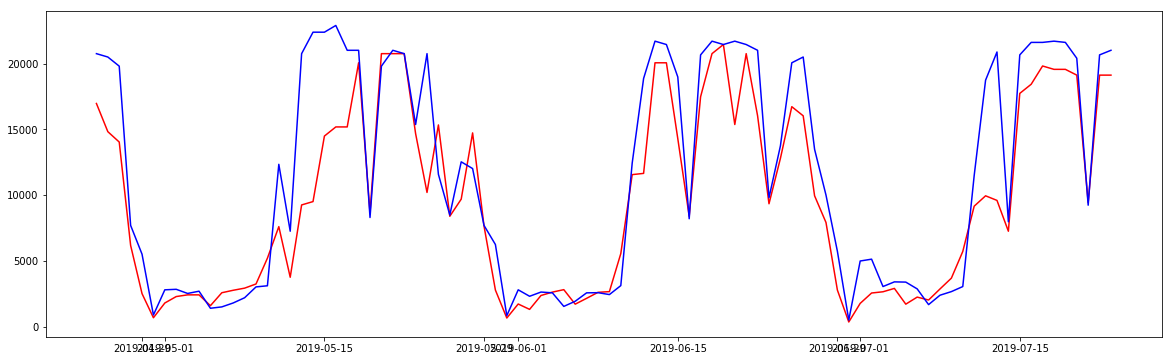

In [46]:
plt.figure(figsize=(20, 6))
plt.plot(df_val_preds_.pred, color='r' ) 
plt.plot(df_val_preds_.true, color='b') 

In [47]:
for i in range(80,121):
    print (i, mean_absolute_percentage_error(df_val_preds_.true, df_val_preds_.pred*(i/100)))

80 33.74813380500828
81 33.17016280441417
82 32.601985882200324
83 32.0512323403865
84 31.536648179545924
85 31.039208863889513
86 30.541769548233116
87 30.044330232576705
88 29.546890916920297
89 29.07391628670136
90 28.601703211758977
91 28.129490136816592
92 27.66594412873656
93 27.217970071532903
94 26.788732083851713
95 26.364590263331962
96 25.954279003359577
97 25.576573596201563
98 25.20747956632362
99 24.897904035500574
100 24.610738183323168
101 24.376508887779437
102 24.192238082821053
103 24.015523967467935
104 23.852990959858108
105 23.73404349351911
106 23.6849839388599
107 23.644080702988468
108 23.657651784886838
109 23.72827730160575
110 23.828560260393157
111 23.979332949368906
112 24.188259018815174
113 24.411595666066994
114 24.647287465187247
115 24.88662090282038
116 25.141661765777563
117 25.408631729374154
118 25.71618429691315
119 26.043797024853227
120 26.393971946700383


In [48]:
te_losses, te_preds, te_true, te_indexes = predict(model=model, dataloader=test_dataloader, device=device)

In [49]:
df_te_preds = pd.DataFrame({
    'ind': te_indexes.astype(int).reshape(1,-1)[0],
#     'case_count': ss_target.inverse_transform(te_preds).astype(int).reshape(1,-1)[0],
    'case_count': np.exp(te_preds.astype(int).reshape(1,-1)[0]) - 1,
    
})
df_te_preds['state'] = df_.iloc[df_te_preds['ind']]['state'].tolist()
df_te_preds['application_date'] = df_.iloc[df_te_preds['ind']]['application_date'].tolist()
df_te_preds_ = df_te_preds.groupby('application_date')[['case_count']].sum().reset_index()
df_te_preds_

,application_date,case_count
0,2019-07-24,18867.177992
1,2019-07-25,18173.973627
2,2019-07-26,10657.491590
3,2019-07-27,10657.491590
4,2019-07-28,8135.232842
5,2019-07-29,6642.468961
6,2019-07-30,2717.917273
7,2019-07-31,685.846763
8,2019-08-01,3018.447837
9,2019-08-02,3052.960450


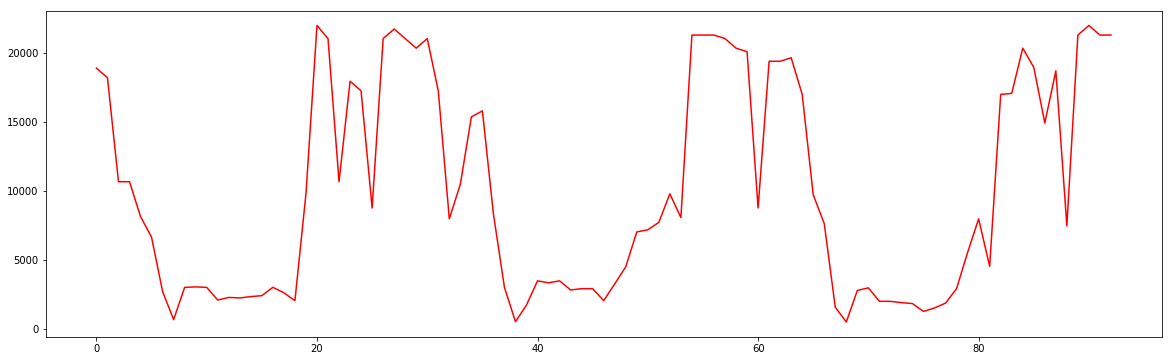

In [50]:
plt.figure(figsize=(20, 6))
plt.plot(df_te_preds_.case_count, color='r' ) 

In [51]:
df_te_preds_.to_csv('segment2_state.csv', index=False)

In [52]:
df_te_preds_.head()

,application_date,case_count
0,2019-07-24,18867.177992
1,2019-07-25,18173.973627
2,2019-07-26,10657.491590
3,2019-07-27,10657.491590
4,2019-07-28,8135.232842


In [53]:
from IPython.display import FileLink
FileLink(r'segment2_state.csv')

/kaggle/working/segment2_state.csv